# Models included

- Raw data
  - Naive Bayes, LightGBM, Isolation Forest

- Normed data
  - SVM, SGD, Naive Bayes, LightGBM, Isolation Forest, one-class SVM



In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import yfinance as yf
import talib
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.metrics import Precision, AUC


import scripts.feature as feat
import scripts.utility as util


# Single ticker

In [2]:
ticker = "TSLA"
df = yf.download(ticker, period="5y", interval="1d", progress=False)
df = df.drop(columns=["Adj Close"])


In [3]:
result_table = pd.DataFrame(columns=["train_recall", "train_precision", "train_f1", "train_fbeta",
                                     "val_recall", "val_precision", "val_f1", "val_fbeta"])


## Multi-category case


In [4]:
def single_class_report(y_true, y_pred, label):
    instance = np.where(y_true == label)[0]
    predict = np.where(y_pred == label)[0]
    correct = np.intersect1d(instance, predict) 

    precision = len(correct) / (len(predict))
    recall = len(correct) / (len(instance))
    
    def fbeta_score(b):
        return (1+b**2) * (precision * recall) / (b**2 * precision + recall)
    f1 = fbeta_score(b=1)
    fbeta = fbeta_score(b=0.5)  # 0.5 beta focus more on precision

    print(f"----- For Class {label} -----")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"f1_score: {f1}")
    print(f"f0.5_score: {fbeta}")

    return [recall, precision, f1, fbeta]


def quick_model_evaluation(model, X_train, y_train, X_val, y_val, label):
    model.fit(X_train, y_train)

    print("train set")
    y_pred = model.predict(X_train)
    train_result = single_class_report(y_train, y_pred, label=label)

    print("val set")
    y_pred = model.predict(X_val)
    val_result = single_class_report(y_val, y_pred, label=label)

    return np.round(train_result + val_result, 3)


def quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label):
    model.fit(X_train)

    # class 1 is normal, -1 is anomaly
    print("train set")
    y_pred = model.predict(X_train)
    y_pred = np.where(y_pred > 0, 0, 1)
    train_result = single_class_report(y_train, y_pred, label=label)

    print("val set")
    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred > 0, 0, 1)
    val_result = single_class_report(y_val, y_pred, label=label)

    return np.round(train_result + val_result, 3)

def update_result_table(df, result, idx_name):
    new = pd.DataFrame(data=[result],
                       columns=["train_recall", "train_precision", "train_f1", "train_fbeta",
                                "val_recall", "val_precision", "val_f1", "val_fbeta"],
                       index=[idx_name])
    df = pd.concat([df, new])
    return df


In [5]:
class_type = "multi"

### Raw data

In [6]:
data_type = "raw"

In [7]:
X_train, y_train, X_val, y_val = feat.raw_dataset_pipeline(df, seq_len=None)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(980, 25) (980,) (245, 25) (245,)
(array([0, 1, 2], dtype=int64), array([389, 112, 479], dtype=int64))
(array([0, 1, 2], dtype=int64), array([112,  53,  80], dtype=int64))


In [8]:
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import IsolationForest



In [9]:
# Build LightGBM model
params = {
    "objective": "multiclass",
    "num_class": 3,
    "metric": "multi_logloss",
    "learning_rate": 0.03,
    "num_leaves": 32,
    "verbose": -1,
    
}


model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.9979123173277662
Precision: 0.987603305785124
f1_score: 0.9927310488058153
f0.5_score: 0.989648033126294
val set
----- For Class 2 -----
Recall: 0.6875
Precision: 0.4230769230769231
f1_score: 0.5238095238095238
f0.5_score: 0.45833333333333337


C:\Users\edton\AppData\Local\Temp\ipykernel_42316\1446241041.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new])


In [10]:
result_table

,train_recall,train_precision,train_f1,train_fbeta,val_recall,val_precision,val_f1,val_fbeta
multi_raw_LGBMClassifier,0.998,0.988,0.993,0.99,0.688,0.423,0.524,0.458


In [11]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.31106471816283926
Precision: 0.6234309623430963
f1_score: 0.4150417827298051
f0.5_score: 0.5191637630662022
val set
----- For Class 2 -----
Recall: 0.1125
Precision: 0.45
f1_score: 0.18000000000000002
f0.5_score: 0.28125000000000006


### Normed data

In [12]:
data_type = "norm"

In [13]:
X_train, y_train, X_val, y_val = feat.norm_dataset_pipeline(df, seq_len=None)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(980, 25) (980,) (245, 25) (245,)
(array([0, 1, 2], dtype=int64), array([389, 112, 479], dtype=int64))
(array([0, 1, 2], dtype=int64), array([112,  53,  80], dtype=int64))


In [14]:
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.9979123173277662
Precision: 0.989648033126294
f1_score: 0.9937629937629938
f0.5_score: 0.9912899211945251
val set
----- For Class 2 -----
Recall: 0.675
Precision: 0.4090909090909091
f1_score: 0.5094339622641509
f0.5_score: 0.4440789473684211


In [15]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.31106471816283926
Precision: 0.6234309623430963
f1_score: 0.4150417827298051
f0.5_score: 0.5191637630662022
val set
----- For Class 2 -----
Recall: 0.1125
Precision: 0.45
f1_score: 0.18000000000000002
f0.5_score: 0.28125000000000006


In [16]:
model = SGDClassifier(loss="log_loss")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.4154488517745303
Precision: 0.46604215456674475
f1_score: 0.4392935982339956
f0.5_score: 0.45496113397347976
val set
----- For Class 2 -----
Recall: 0.5875
Precision: 0.34558823529411764
f1_score: 0.4351851851851852
f0.5_score: 0.37660256410256404


In [17]:
model = SVC(kernel="rbf")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.860125260960334
Precision: 0.5613079019073569
f1_score: 0.6793075020610058
f0.5_score: 0.6032210834553441
val set
----- For Class 2 -----
Recall: 0.7875
Precision: 0.38181818181818183
f1_score: 0.5142857142857142
f0.5_score: 0.4256756756756757


## Binary case

In [18]:
class_type = "binary"

### Raw data

In [19]:
data_type = "raw"

In [20]:
X_train, y_train, X_val, y_val = feat.raw_dataset_pipeline(df, seq_len=None)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

y_train = np.where(y_train <= 1, 0, 1)
y_val = np.where(y_val <= 1, 0, 1)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(980, 25) (980,) (245, 25) (245,)
(array([0, 1]), array([501, 479], dtype=int64))
(array([0, 1]), array([165,  80], dtype=int64))


In [21]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.03,
    "num_leaves": 32,
    "verbose": -1,
    
}
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.9874739039665971
Precision: 0.9813278008298755
f1_score: 0.9843912591050988
f0.5_score: 0.9825508932280849
val set
----- For Class 1 -----
Recall: 0.5875
Precision: 0.42727272727272725
f1_score: 0.49473684210526325
f0.5_score: 0.4519230769230769


In [22]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.3945720250521921
Precision: 0.6077170418006431
f1_score: 0.47848101265822784
f0.5_score: 0.5484619849100407
val set
----- For Class 1 -----
Recall: 0.1375
Precision: 0.4230769230769231
f1_score: 0.20754716981132076
f0.5_score: 0.29891304347826086


In [23]:
# This wont be good enough as contamination too low in train
model = IsolationForest(contamination=0.5)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")


train set
----- For Class 1 -----
Recall: 0.5365344467640919
Precision: 0.5244897959183673
f1_score: 0.5304437564499485
f0.5_score: 0.5268552685526855
val set
----- For Class 1 -----
Recall: 0.3625
Precision: 0.34523809523809523
f1_score: 0.3536585365853659
f0.5_score: 0.34855769230769235


### Normed data

In [24]:
data_type = "norm"

In [25]:
X_train, y_train, X_val, y_val = feat.norm_dataset_pipeline(df, seq_len=None)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

y_train = np.where(y_train <= 1, 0, 1)
y_val = np.where(y_val <= 1, 0, 1)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(980, 25) (980,) (245, 25) (245,)
(array([0, 1]), array([501, 479], dtype=int64))
(array([0, 1]), array([165,  80], dtype=int64))


In [26]:
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.9832985386221295
Precision: 0.9771784232365145
f1_score: 0.9802289281997919
f0.5_score: 0.9783963439966765
val set
----- For Class 1 -----
Recall: 0.575
Precision: 0.4380952380952381
f1_score: 0.4972972972972973
f0.5_score: 0.45999999999999996


In [27]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.3945720250521921
Precision: 0.6077170418006431
f1_score: 0.47848101265822784
f0.5_score: 0.5484619849100407
val set
----- For Class 1 -----
Recall: 0.1375
Precision: 0.4230769230769231
f1_score: 0.20754716981132076
f0.5_score: 0.29891304347826086


In [28]:
model = SGDClassifier(loss="log_loss")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.38413361169102295
Precision: 0.49066666666666664
f1_score: 0.4309133489461358
f0.5_score: 0.4648812531581607
val set
----- For Class 1 -----
Recall: 0.5625
Precision: 0.3191489361702128
f1_score: 0.4072398190045249
f0.5_score: 0.34937888198757766


In [29]:
model = SVC(kernel="rbf")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.4613778705636743
Precision: 0.6971608832807571
f1_score: 0.5552763819095476
f0.5_score: 0.6325128792215226
val set
----- For Class 1 -----
Recall: 0.1375
Precision: 0.3333333333333333
f1_score: 0.1946902654867257
f0.5_score: 0.259433962264151


In [30]:
# This wont be good enough as contamination too low in train
model = IsolationForest(contamination=0.5)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.5386221294363257
Precision: 0.5265306122448979
f1_score: 0.5325077399380804
f0.5_score: 0.5289052890528905
val set
----- For Class 1 -----
Recall: 0.4125
Precision: 0.336734693877551
f1_score: 0.3707865168539326
f0.5_score: 0.3495762711864407


In [31]:
model = OneClassSVM(kernel="rbf", nu=0.2)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.2254697286012526
Precision: 0.5538461538461539
f1_score: 0.32047477744807124
f0.5_score: 0.4289118347895155
val set
----- For Class 1 -----
Recall: 0.0875
Precision: 0.6363636363636364
f1_score: 0.15384615384615383
f0.5_score: 0.282258064516129


# Final results in heatmap

<Axes: >

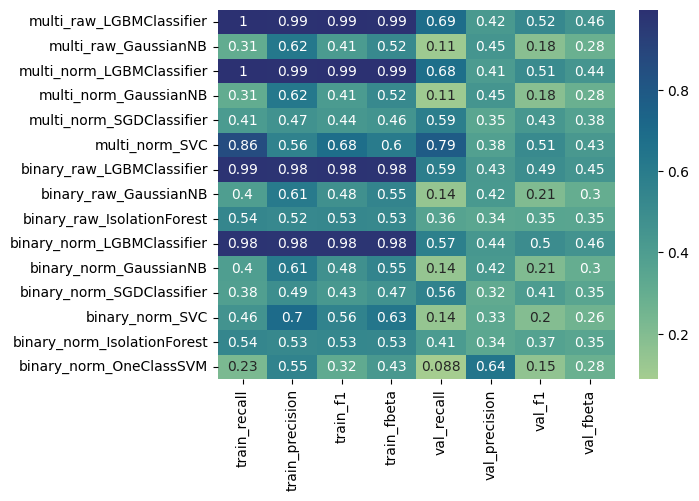

In [37]:
sns.heatmap(result_table, annot=True, cmap="crest")
